v3: use "crorisId" as the primary identifier for authors

In [ ]:
# Install required packages
!pip install torch_geometric nltk -U einops colbert-ai triton pylate
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28

In [5]:
from google.colab import drive
import os
import sys
import re
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pyarrow.parquet as pq
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from pylate import models, indexes, retrieve
import json
import ast

# Download NLTK resources
nltk.download('stopwords', quiet=True)

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_texts(texts):
    """Preprocess a list of texts."""
    preprocessed_texts = []
    for text in tqdm(texts, desc="Preprocessing texts"):
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words]
        preprocessed_texts.append(' '.join(tokens))
    return preprocessed_texts

def extract_author_info(osobeResources):
    author_info = []
    if isinstance(osobeResources, str):
        try:
            osobeResources = ast.literal_eval(osobeResources)
        except (ValueError, SyntaxError):
            print(f"Failed to parse osobeResources: {osobeResources[:200]}...")
            return author_info

    if isinstance(osobeResources, dict):
        osobe = osobeResources.get('_embedded', {}).get('osobe', [])
        for osoba in osobe:
            author_info.append({
                'crorisId': osoba.get('crorisId'),
                'ime': osoba.get('ime'),
                'prezime': osoba.get('prezime')
            })
    elif osobeResources is not None:
        print(f"Unexpected type for osobeResources: {type(osobeResources)}")
        print(f"Content: {str(osobeResources)[:200]}...")
    return author_info

def load_data(parquet_file):
    try:
        table = pq.read_table(parquet_file)
        df = table.to_pandas()
        filtered_df = df[df['tip'] == "izvorni znanstveni rad"]
        data_list = filtered_df.to_dict('records')

        for item in data_list:
            item['author_info'] = extract_author_info(item.get('osobeResources'))

        print(f"Finished reading Parquet file. Loaded {len(df)} publications")
        print(f"After filtering for 'izvorni znanstveni rad': {len(data_list)} publications")

        # Print sample data for debugging
        print("\nSample of data:")
        for item in data_list[:5]:
            print(f"Title: {item.get('naslov', '')}")
            print(f"Authors: {item.get('author_info', [])}")
            print(f"osobeResources type: {type(item.get('osobeResources', ''))}")
            print(f"osobeResources content: {str(item.get('osobeResources', ''))[:200]}...")  # Print first 200 characters
            print("---")

        return data_list
    except FileNotFoundError:
        print("fullPublications.parquet not found. Please ensure the file exists in the current directory.")
        sys.exit(1)
    except Exception as e:
        print(f"Unexpected error while loading the data: {str(e)}")
        sys.exit(1)

def create_collection(data_list):
    """Create a collection from the data list for indexing."""
    collection = []
    for item in tqdm(data_list, desc="Creating collection"):
        pid = item.get('id', '')
        naslov = item.get('naslov', '')
        sazeci = item.get('sazeci', [])
        if isinstance(sazeci, list):
            sazeci = ' '.join([s.get('naziv', '') for s in sazeci if isinstance(s, dict)])
        text = f"{naslov} {sazeci}"
        collection.append((pid, text))
    return collection

def save_graph(G, filename):
    nx.write_gexf(G, get_drive_path(filename))
    print(f"Graph saved to {filename}")

def save_embeddings(embeddings, filename):
    np.save(get_drive_path(filename), embeddings)
    print(f"Embeddings saved to {filename}")

def build_coauthorship_graph(data_list):
    print("Building co-authorship graph")
    G = nx.Graph()
    author_info = {}  # Dictionary to store author information

    for item in tqdm(data_list, desc="Processing publications"):
        authors = item.get('author_info', [])
        for author in authors:
            crorisId = author.get('crorisId')
            if crorisId:
                if crorisId not in G:
                    G.add_node(crorisId)
                # Store author information
                author_info[str(crorisId)] = {
                    'ime': author.get('ime', ''),
                    'prezime': author.get('prezime', '')
                }

        author_ids = [author.get('crorisId') for author in authors if author.get('crorisId')]
        for i in range(len(author_ids)):
            for j in range(i+1, len(author_ids)):
                author1 = author_ids[i]
                author2 = author_ids[j]
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

    print(f"Co-authorship graph built. Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f"Author info collected for {len(author_info)} authors")

    # Save author_info to a JSON file
    with open(get_drive_path('author_info.json'), 'w') as f:
        json.dump(author_info, f)
    print("Author info saved to author_info.json")

    return G, author_info

class GNN(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

def reduce_dataset(data_list, strategy='random', sample_size=100, **kwargs):
    """Reduce the dataset size based on the chosen strategy."""
    if strategy == 'random':
        return random.sample(data_list, min(sample_size, len(data_list)))
    elif strategy == 'publication_type':
        publication_type = kwargs.get('publication_type', 'izvorni znanstveni rad')
        filtered = [item for item in data_list if item.get('tip') == publication_type]
        return filtered[:sample_size]
    elif strategy == 'time_based':
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        filtered = [item for item in data_list if start_date <= item.get('date') <= end_date]
        return filtered[:sample_size]
    elif strategy == 'author_count':
        min_authors = kwargs.get('min_authors', 1)
        max_authors = kwargs.get('max_authors', float('inf'))
        filtered = [item for item in data_list if min_authors <= len(item.get('author_info', [])) <= max_authors]
        return filtered[:sample_size]
    else:
        raise ValueError("Invalid strategy. Choose 'random', 'publication_type', 'time_based', or 'author_count'.")

def create_publication_embeddings(data_list, model, coauthorship_graph, author_info):
    print("Starting publication embedding creation process")

    try:
        texts = [f"{item.get('naslov', '')} {' '.join([s.get('naziv', '') for s in item.get('sazeci', []) if isinstance(s, dict)])}" for item in tqdm(data_list, desc="Preparing texts")]

        print(f"Texts to encode: {texts[:2]}...")  # Print first two texts
        print(f"Number of texts: {len(texts)}")

        # Implement batching
        batch_size = 1024  # Adjust this based on your available memory
        publication_embeddings = []

        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding batches"):
            batch_texts = texts[i:i+batch_size]
            try:
                batch_embeddings = model.encode(batch_texts)

                if batch_embeddings is None:
                    print(f"Warning: model.encode() returned None for batch {i//batch_size + 1}")
                    print(f"Batch texts: {batch_texts}")
                    continue

                # Handle the case where batch_embeddings is a list
                if isinstance(batch_embeddings, list):
                    batch_embeddings = np.array(batch_embeddings)

                # If the embeddings are 3D (batch_size, sequence_length, embedding_dim),
                # average over the sequence length dimension
                if len(batch_embeddings.shape) == 3:
                    batch_embeddings = batch_embeddings.mean(axis=1)

                if isinstance(batch_embeddings, torch.Tensor):
                    batch_embeddings = batch_embeddings.cpu().numpy()

                publication_embeddings.append(batch_embeddings)
                print(f"Batch {i//batch_size + 1} shape: {batch_embeddings.shape}")
            except Exception as e:
                print(f"Error encoding batch {i//batch_size + 1}: {str(e)}")
                print(f"Batch texts: {batch_texts}")

        if not publication_embeddings:
            raise ValueError("All batches failed to encode")

        publication_embeddings = np.concatenate(publication_embeddings, axis=0)
        print(f"Final publication embeddings shape: {publication_embeddings.shape}")

        coauthorship_graph, author_info = build_coauthorship_graph(data_list)
        author_to_index = {author: i for i, author in enumerate(coauthorship_graph.nodes())}

        edge_index = torch.tensor([[author_to_index[edge[0]], author_to_index[edge[1]]] for edge in coauthorship_graph.edges()]).t().contiguous()

        x = torch.zeros((len(author_to_index), publication_embeddings.shape[1]))
        author_publication_counts = {author: 0 for author in author_to_index}
        for idx, item in enumerate(data_list):
            for author_info in item.get('author_info', []):
                crorisId = author_info.get('crorisId')
                if crorisId in author_to_index:
                    x[author_to_index[crorisId]] += torch.tensor(publication_embeddings[idx], dtype=torch.float)
                    author_publication_counts[crorisId] += 1

        for author, count in author_publication_counts.items():
            if count > 0:
                x[author_to_index[author]] /= count

        data = Data(x=x, edge_index=edge_index)

        input_dim = x.shape[1]
        hidden_dim = 128
        gnn_model = GNN(input_dim, hidden_dim)

        optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
        num_epochs = 100
        for epoch in tqdm(range(num_epochs), desc="Training GNN"):
            optimizer.zero_grad()
            out = gnn_model(data.x, data.edge_index)
            loss = F.mse_loss(out, data.x)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            final_embeddings = gnn_model(data.x, data.edge_index).cpu().numpy()

        author_final_embeddings = {author: final_embeddings[idx] for author, idx in author_to_index.items()}

        print("Author embedding creation completed")
        return author_final_embeddings

    except Exception as e:
        print(f"An error occurred during the author embedding creation process: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def visualize_embeddings(author_embeddings, author_info, n_components=2, perplexity=30, n_iter=1000):
    print("Starting t-SNE visualization...")
    embeddings = np.array(list(author_embeddings.values()))
    author_ids = list(author_embeddings.keys())

    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, verbose=1)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(20, 16))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

    # Add labels for a subset of points (e.g., top 100 authors)
    top_authors = sorted(author_publication_counts.items(), key=lambda x: x[1], reverse=True)[:100]
    for crorisId, _ in top_authors:
        idx = author_ids.index(crorisId)
        plt.annotate(author_info.get(crorisId, str(crorisId)),
                     (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
                     xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                     arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.title('t-SNE visualization of author embeddings')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.savefig(get_drive_path('author_embeddings_tsne.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print("t-SNE visualization completed and saved.")

def calculate_author_scores(data_list):
    author_scores = {}
    for item in data_list:
        authors = item.get('author_info', [])
        if authors:
            weight = 1.0 / len(authors)
            for author in authors:
                crorisId = author.get('crorisId')
                if crorisId:
                    author_scores[crorisId] = author_scores.get(crorisId, 0) + weight
    return author_scores

def get_author_name(author_info, crorisId):
    #print(f"Debug: author_info type: {type(author_info)}")
    #print(f"Debug: author_info content: {author_info}")
    #print(f"crorisId: {crorisId}")

    if isinstance(author_info, dict):
        author_data = author_info.get(str(crorisId))
        if isinstance(author_data, dict):
            ime = author_data.get('ime', '')
            prezime = author_data.get('prezime', '')
            if ime and prezime:
                return f"{ime} {prezime}"
    return f"Unknown (crorisId: {crorisId})"

def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

def find_max_authors_publication(data_list):
    max_authors = 0
    max_pub = None
    for item in data_list:
        authors = item.get('author_info', [])
        if len(authors) > max_authors:
            max_authors = len(authors)
            max_pub = item
    return max_pub, max_authors

def plot_author_count_distribution(data_list):
    author_counts = [len(item.get('author_info', [])) for item in data_list]
    plt.figure(figsize=(12, 6))
    plt.hist(author_counts, bins=50, edgecolor='black')
    plt.title('Distribution of Author Counts')
    plt.xlabel('Number of Authors')
    plt.ylabel('Frequency')
    plt.savefig(get_drive_path('author_count_distribution.png'))
    plt.close()

if __name__ == "__main__":
    print("Starting author-to-vector process")

    try:
        # Mount Google Drive
        drive.mount('/content/drive')

        # Set the path to the auth2vec folder in your Google Drive
        auth2vec_folder = "/content/drive/My Drive/auth2vec"

        # Create a function to get a path in the auth2vec folder
        def get_drive_path(filename):
            return os.path.join(auth2vec_folder, filename)

        # Set the path to the parquet file
        parquet_file = os.path.join(auth2vec_folder, "fullPublications.parquet")

        # Load the Jina-ColBERT model using pylate
        print("Loading Jina-ColBERT model...")
        model = models.ColBERT(
            model_name_or_path="jinaai/jina-colbert-v2",
            query_prefix="[QueryMarker]",
            document_prefix="[DocumentMarker]",
            attend_to_expansion_tokens=True,
            trust_remote_code=True,
        )
        print(f"Model type: {type(model)}")
        print(f"Model attributes: {dir(model)}")

        # Load data
        print("Loading data...")
        data_list = load_data(parquet_file)
        print(f"Full dataset size: {len(data_list)}")

        # Call this function after loading the data
        max_pub, max_authors = find_max_authors_publication(data_list)
        print(f"Publication with most authors: {max_pub.get('naslov', 'No title')}")
        print(f"Maximum number of authors: {max_authors}")

        # Add this check after loading the data
        max_authors_publication = max(data_list, key=lambda x: len(x.get('author_info', [])))
        print(f"Max authors in a single publication: {len(max_authors_publication.get('author_info', []))}")
        print(f"Title of max authors publication: {max_authors_publication.get('naslov', 'No title')}")

        plot_author_count_distribution(data_list)

        print("Sample of data:")
        for item in data_list[:5]:
            print(f"Title: {item.get('naslov', '')}")
            print(f"Authors: {item.get('author_info', [])}")
            print(f"Abstract: {item.get('sazeci', '')[:100]}...")
            print("---")

        # Print sample of data
        print("Sample of data:")
        for item in tqdm(data_list[:2], desc="Printing sample"):
            print(f"Title: {item.get('naslov', '')}")
            print(f"Authors: {item.get('author_info', '')}")
            print(f"Abstract: {item.get('sazeci', '')[:100]}...")  # Print first 100 characters of abstract
            print("---")

        # Create author embeddings
        print("Starting author embedding creation...")
        coauthorship_graph, author_info = build_coauthorship_graph(data_list)

        if coauthorship_graph.number_of_nodes() == 0:
            print("The co-authorship graph is empty. Unable to create author embeddings.")
            sys.exit(1)

        author_embeddings = create_publication_embeddings(data_list, model, coauthorship_graph, author_info)
        if author_embeddings is None:
            print("Failed to create author embeddings. Exiting.")
            sys.exit(1)
        print(f"Author embeddings created. Number of authors: {len(author_embeddings)}")
        save_embeddings(author_embeddings, "author_embeddings.npy")

        # Convert author embeddings to numpy arrays
        print("Converting embeddings to numpy arrays...")
        author_embeddings = {author: np.array(embedding) for author, embedding in tqdm(author_embeddings.items(), desc="Converting embeddings")}

        # Save the embeddings
        print("Saving embeddings...")
        np.save(get_drive_path('author_embeddings.npy'), np.array(list(author_embeddings.values())))

        visualize_embeddings(author_embeddings, author_info)

        print("Embeddings saved and visualization created.")

        # Additional analysis: Most prolific authors
        author_publication_counts = {}
        for item in data_list:
            for author in item.get('author_info', []):
                crorisId = author.get('crorisId')
                if crorisId:
                    author_publication_counts[crorisId] = author_publication_counts.get(crorisId, 0) + 1

        author_scores = calculate_author_scores(data_list)

        top_authors = sorted(author_scores.items(), key=lambda x: x[1], reverse=True)[:10]
        print("\nTop 10 most prolific authors (weighted by number of co-authors):")
        for crorisId, score in top_authors:
            author_name = get_author_name(author_info, crorisId)
            print(f"{crorisId} - {author_name}: {score:.2f} weighted publications")

        # Additional analysis: Co-authorship network statistics
        print("\nCo-authorship network statistics:")
        print(f"Number of nodes (authors): {coauthorship_graph.number_of_nodes()}")
        print(f"Number of edges (co-authorships): {coauthorship_graph.number_of_edges()}")
        print(f"Network density: {nx.density(coauthorship_graph):.4f}")

        largest_cc = max(nx.connected_components(coauthorship_graph), key=len)
        print(f"Size of the largest connected component: {len(largest_cc)}")

        # Add author count statistics
        author_counts = [len(item.get('author_info', [])) for item in data_list if item.get('author_info')]
        author_count_stats = {
            "mean": np.mean(author_counts),
            "median": np.median(author_counts),
            "min": np.min(author_counts),
            "max": np.max(author_counts),
            "95th_percentile": np.percentile(author_counts, 95)
        }

        print("\nUpdated Author count statistics:")
        for stat, value in author_count_stats.items():
            print(f"{stat}: {value:.2f}")

        # Update the results dictionary:
        results = {
            "top_authors": [
                (
                    str(crorisId),
                    float(score),
                    get_author_name(author_info, crorisId)
                ) for crorisId, score in top_authors
            ],
            "network_stats": {
                "nodes": int(coauthorship_graph.number_of_nodes()),
                "edges": int(coauthorship_graph.number_of_edges()),
                "density": float(nx.density(coauthorship_graph)),
                "largest_cc_size": int(len(largest_cc))
            },
            "author_count_stats": {
                key: float(value) if isinstance(value, np.number) else value
                for key, value in author_count_stats.items()
            }
        }

        with open(get_drive_path('analysis_results.json'), 'w') as f:
            json.dump(results, f, indent=2, default=convert_to_serializable)

        print("Analysis results saved to analysis_results.json")

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

    print("Author-to-vector process completed")

Mounted at /content/drive


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import os

def load_data(parquet_file):
    table = pq.read_table(parquet_file)
    df = table.to_pandas()
    return df

def calculate_dataset_statistics(df):
    total_publications = len(df)
    print(f"Total number of publications: {total_publications}")

    df['godina'] = pd.to_datetime(df['godina'], format='%Y', errors='coerce')
    date_distribution = df['godina'].dt.year.value_counts().sort_index()

    df['num_authors'] = df['autori'].str.split(';').str.len()
    author_distribution = df['num_authors'].value_counts().sort_index()

    return date_distribution, author_distribution

def plot_publication_dates(date_distribution):
    plt.figure(figsize=(12, 6))
    date_distribution.plot(kind='line')
    plt.title('Distribution of Publication Dates')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('publication_dates.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_publication_years_histogram(df):
    plt.figure(figsize=(15, 8))

    # Get the range of years
    min_year = df['godina'].dt.year.min()
    max_year = df['godina'].dt.year.max()

    # Create bins for each year
    bins = range(min_year, max_year + 2)  # +2 to include the last year

    # Plot the histogram with specified bins
    df['godina'].dt.year.hist(bins=bins, edgecolor='black', align='left')

    plt.title('Histogram of Publication Years')
    plt.xlabel('Year')
    plt.ylabel('Count')

    # Set x-ticks to show every 5 years
    plt.xticks(range(min_year, max_year + 1, 5), rotation=45)

    plt.tight_layout()
    plt.savefig('publication_years_histogram.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_authors_distribution(author_distribution):
    plt.figure(figsize=(12, 6))
    author_distribution[author_distribution.index <= 20].plot(kind='bar', logy=True)
    plt.title('Distribution of Number of Authors per Publication (up to 20)')
    plt.xlabel('Number of Authors')
    plt.ylabel('Count (log scale)')
    plt.xticks(range(len(author_distribution[author_distribution.index <= 20])),
               [int(i) for i in author_distribution[author_distribution.index <= 20].index],
               rotation=0)
    plt.tight_layout()
    plt.savefig('authors_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_authors_boxplot(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['num_authors'])
    plt.title('Boxplot of Number of Authors per Publication')
    plt.xlabel('Number of Authors')
    plt.tight_layout()
    plt.savefig('authors_boxplot.png', dpi=300, bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    parquet_file = os.path.join(auth2vec_folder, "fullPublications.parquet")
    df = load_data(parquet_file)

    date_distribution, author_distribution = calculate_dataset_statistics(df)

    plot_publication_dates(date_distribution)
    plot_publication_years_histogram(df)
    plot_authors_distribution(author_distribution)
    plot_authors_boxplot(df)

    print("Improved dataset statistics have been calculated and visualized.")
    print("Check the following PNG files for the plots:")
    print("- publication_dates.png")
    print("- publication_years_histogram.png")
    print("- authors_distribution.png")
    print("- authors_boxplot.png")

    # Print additional insights
    print(f"Year range: {date_distribution.index.min()} to {date_distribution.index.max()}")
    print(f"Median number of authors per publication: {df['num_authors'].median()}")
    print(f"Maximum number of authors in a single publication: {df['num_authors'].max()}")

    # Calculate mean and standard deviation
    mean_authors = df['num_authors'].mean()
    std_authors = df['num_authors'].std()

    # Calculate percentiles
    percentiles = df['num_authors'].quantile([0.25, 0.75])
    p25 = percentiles[0.25]
    p75 = percentiles[0.75]

    # Calculate median (already done in your code, but included here for completeness)
    median_authors = df['num_authors'].median()

    # Maximum number of authors (already calculated, but included here for completeness)
    max_authors = df['num_authors'].max()

    # Print results
    print("Author Collaboration Patterns:")
    print(f"- Median number of authors per publication: {median_authors:.2f}")
    print(f"- Mean number of authors per publication: {mean_authors:.2f}")
    print(f"- Standard deviation: {std_authors:.2f}")
    print(f"- 25th percentile: {p25:.2f}")
    print(f"- 75th percentile: {p75:.2f}")
    print(f"- Maximum number of authors on a single publication: {max_authors:.0f}")

    # If you want to calculate the interquartile range (IQR)
    iqr = p75 - p25
    print(f"- Interquartile range: {iqr:.2f}")


Total number of publications: 225302
Improved dataset statistics have been calculated and visualized.
Check the following PNG files for the plots:
- publication_dates.png
- publication_years_histogram.png
- authors_distribution.png
- authors_boxplot.png
Year range: 2004 to 2026
Median number of authors per publication: 3.0
Maximum number of authors in a single publication: 331.0
Author Collaboration Patterns:
- Median number of authors per publication: 3.00
- Mean number of authors per publication: 3.91
- Standard deviation: 7.90
- 25th percentile: 1.00
- 75th percentile: 4.00
- Maximum number of authors on a single publication: 331
- Interquartile range: 3.00


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from community import community_louvain
import seaborn as sns

def coauthorship_network_analysis(G):
    print("Starting Co-authorship Network Analysis")

    # 1. Network statistics
    print("\n1. Network Statistics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Network density: {nx.density(G):.4f}")
    print(f"Number of connected components: {nx.number_connected_components(G)}")

    # 2. Degree distribution plot
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=50)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.savefig("degree_distribution.png")
    plt.close()

    # 4. Community detection and visualization
    print("\n4. Community Detection and Visualization:")

    # Detect communities
    communities = community_louvain.best_partition(G)

    # Count the number of communities
    num_communities = len(set(communities.values()))
    print(f"Number of communities detected: {num_communities}")

    # Visualize the network with communities (for a subset of nodes if the network is large)
    plt.figure(figsize=(20, 20))

    # If the network is too large, visualize only a subset
    if G.number_of_nodes() > 1000:
        subG = G.subgraph(list(G.nodes())[:1000])
    else:
        subG = G

    pos = nx.spring_layout(subG)

    # Color nodes based on community
    colors = [communities[node] for node in subG.nodes()]

    nx.draw(subG, pos, node_color=colors, with_labels=False, node_size=30, cmap=plt.cm.rainbow)
    plt.title("Co-authorship Network Communities")
    plt.savefig("coauthorship_communities.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Visualize community size distribution
    community_sizes = [len([n for n in G.nodes() if communities[n] == c]) for c in set(communities.values())]
    plt.figure(figsize=(10, 6))
    sns.histplot(community_sizes, kde=True)
    plt.title("Community Size Distribution")
    plt.xlabel("Community Size")
    plt.ylabel("Frequency")
    plt.savefig("community_size_distribution.png")
    plt.close()

    print("Co-authorship Network Analysis completed. Visualizations saved.")

# Assuming you have already built the co-authorship graph G
coauthorship_network_analysis(coauthorship_graph)

Starting Co-authorship Network Analysis

1. Network Statistics:
Number of nodes: 25582
Number of edges: 223419
Average degree: 17.47
Network density: 0.0007
Number of connected components: 112

4. Community Detection and Visualization:
Number of communities detected: 143
Co-authorship Network Analysis completed. Visualizations saved.


In [ ]:
import numpy as np

author_embeddings_file = os.path.join(auth2vec_folder, "author_embeddings.npy")
embeddings = np.load(author_embeddings_file, allow_pickle=True)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_authors(author_index, top_n=5):
    similarities = cosine_similarity([embeddings[author_index]], embeddings)[0]
    most_similar = similarities.argsort()[-top_n-1:-1][::-1]
    return [(i, similarities[i]) for i in most_similar]

# Example usage:
similar_authors = find_similar_authors(0)  # Find authors similar to the first author
similar_authors

[(18319, 1.0000002),
 (23554, 1.0000002),
 (11432, 1.0000001),
 (11156, 1.0000001),
 (24025, 1.0000001)]

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
print(clusters)

[5 1 1 ... 8 4 8]


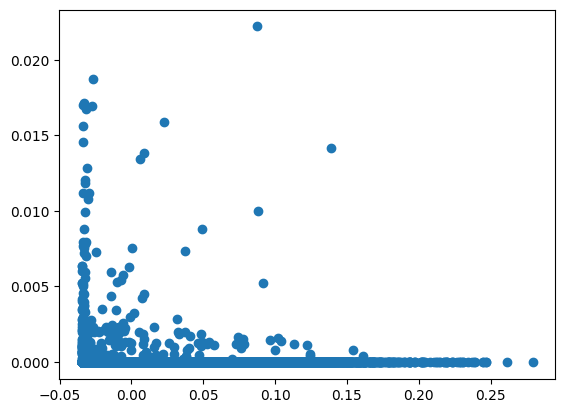

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the results
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

# Perform LDA for topic modeling
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_distribution = lda.fit_transform(np.abs(list(author_embeddings.values())))  # Using absolute values

# Assign authors to topics
author_topics = {}
for i, author in enumerate(author_embeddings.keys()):
    top_topic = topic_distribution[i].argmax()
    author_topics[author] = top_topic

# Print authors for each topic
for topic in range(n_topics):
    topic_authors = [author for author, author_topic in author_topics.items() if author_topic == topic]
    print(f"Topic {topic}: {len(topic_authors)} authors")
    print(f"Sample authors: {', '.join(get_author_name(author_info, author) for author in topic_authors[:5])}")
    print()

Topic 0: 6456 authors
Sample authors: Filip Šuligoj, Dragan Gamberger, Josip Peranić, Snježana Mihalić Arbanas, Željko Arbanas

Topic 1: 7972 authors
Sample authors: Ivan Prskalo, Zoran Krupka, Isabella Matticchio, Damjan Pelc, Marin Lukas

Topic 2: 3081 authors
Sample authors: Branimir Vukosav, Marijana Kresić Vukosav, Boris Badurina, Sanda Dubravčić-Šimunjak, Petra Rajić Šikanjić

Topic 3: 4 authors
Sample authors: Siniša Radović, Maja Mitrović, Matea Dvorščak, Nives Rumenjak

Topic 4: 4777 authors
Sample authors: Hrvoje Jurić, Ivana Šutej, Darko Božić, Kristina Peroš, Darije Plančak

Topic 5: 1395 authors
Sample authors: Tena Šimunjak, Vesna Boraska, Mirjana Babić Leko, Magda Sindičić, Božidar Šantek

Topic 6: 0 authors
Sample authors: 

Topic 7: 0 authors
Sample authors: 

Topic 8: 0 authors
Sample authors: 

Topic 9: 3279 authors
Sample authors: Monika Mladenović, Divna Krpan, Đurđana Ozretić Došen, Cathy-Theresa Kolega, Ante Punda



In [39]:
from sklearn.cluster import KMeans

# Perform K-means clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(list(author_embeddings.values()))

# Assign authors to clusters
author_clusters = {}
for i, author in enumerate(author_embeddings.keys()):
    author_clusters[author] = cluster_labels[i]

# Print authors for each cluster
for cluster in range(n_clusters):
    cluster_authors = [author for author, author_cluster in author_clusters.items() if author_cluster == cluster]
    print(f"Cluster {cluster}: {len(cluster_authors)} authors")
    print(f"Sample authors: {', '.join(get_author_name(author_info, author) for author in cluster_authors[:5])}")
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: 4395 authors
Sample authors: Stjepko Krehula, Svetozar Musić, Tena Šimunjak, Veselin Škrabić, Vesna Boraska

Cluster 1: 1522 authors
Sample authors: Branimir Vukosav, Marijana Kresić Vukosav, Anita Rapan Papeša, Mirjana Sanader, Boško Pešić

Cluster 2: 1453 authors
Sample authors: Hrvoje Jurić, Ivana Šutej, Darije Plančak, Željko Verzak, Damir Sekulić

Cluster 3: 1120 authors
Sample authors: Tanja Šestanj-Perić, Miroslav Bistrović, Danijel Carev, Damir Pavlović, Daša Bosanac

Cluster 4: 940 authors
Sample authors: Ivan Perić, Boris Badurina, Ivana Fojs, Kristina Detelj, Ljubica Ranogajec

Cluster 5: 2469 authors
Sample authors: Monika Mladenović, Divna Krpan, Đurđana Ozretić Došen, Mario Šestan, Nataša Kovačić

Cluster 6: 3446 authors
Sample authors: Filip Šuligoj, Dragan Gamberger, Mirna Gilman Ranogajec, Vlasta Roška, Dalida Rittossa

Cluster 7: 764 authors
Sample authors: Željko Heimer, Antun Husinec, TOMISLAV BILIĆ, Nina Lončar, Maša Surić

Cluster 8: 7377 authors
Sample

In [56]:
import numpy as np
import json
from collections import OrderedDict

def load_embeddings(file_path):
    return np.load(file_path, allow_pickle=True)

def get_author_name(author_info, author_id):
    author_data = author_info.get(str(author_id))
    if author_data:
        return f"{author_data.get('ime', '')} {author_data.get('prezime', '')}".strip()
    return f"Unknown (ID: {author_id})"

# Load embeddings and author info
author_embeddings = load_embeddings(get_drive_path('author_embeddings.npy'))
with open(get_drive_path('author_info.json'), 'r') as f:
    author_info = json.load(f)

# Create a sorted list of author_info IDs
sorted_author_info_ids = sorted(author_info.keys(), key=int)

# Create a mapping between sequential IDs and author_info IDs
id_mapping = {i: author_id for i, author_id in enumerate(sorted_author_info_ids)}

# Create aligned embeddings and author info
aligned_embeddings = OrderedDict()
aligned_author_info = OrderedDict()

for i, emb in enumerate(author_embeddings):
    if i < len(id_mapping):
        author_id = id_mapping[i]
        aligned_embeddings[author_id] = emb
        aligned_author_info[author_id] = author_info[author_id]

print(f"Total aligned authors: {len(aligned_embeddings)}")

# Print sample of aligned authors
print("\nSample of aligned authors:")
for i, (author_id, emb) in enumerate(aligned_embeddings.items()):
    if i >= 10:
        break
    author_name = get_author_name(aligned_author_info, author_id)
    print(f"ID: {author_id}, Name: {author_name}, Embedding shape: {emb.shape}")

# Check for any remaining mismatches
embedding_ids = set(aligned_embeddings.keys())
author_info_ids = set(aligned_author_info.keys())

missing_in_embeddings = author_info_ids - embedding_ids
missing_in_author_info = embedding_ids - author_info_ids

print(f"\nIDs in aligned author_info but not in aligned embeddings: {len(missing_in_embeddings)}")
print(f"IDs in aligned embeddings but not in aligned author_info: {len(missing_in_author_info)}")

# Now you can proceed with your clustering and analysis using the aligned_embeddings and aligned_author_info

Total aligned authors: 26964

Sample of aligned authors:
ID: 1, Name: Petra Udovičić, Embedding shape: (128,)
ID: 4, Name: Lucija Vusić, Embedding shape: (128,)
ID: 23, Name: Ivana Mandić Hekman, Embedding shape: (128,)
ID: 24, Name: Gordan Šarić, Embedding shape: (128,)
ID: 25, Name: Davor Vagić, Embedding shape: (128,)
ID: 26, Name: Predrag Pale, Embedding shape: (128,)
ID: 28, Name: Anica Hunjet, Embedding shape: (128,)
ID: 31, Name: Milena Žic Fuchs, Embedding shape: (128,)
ID: 32, Name: Sanja Biškup, Embedding shape: (128,)
ID: 33, Name: Davor Tomas, Embedding shape: (128,)

IDs in aligned author_info but not in aligned embeddings: 0
IDs in aligned embeddings but not in aligned author_info: 0


In [58]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json
import random
from collections import OrderedDict

def load_embeddings(file_path):
    return np.load(file_path, allow_pickle=True)

def get_author_name(author_info, author_id):
    author_data = author_info.get(str(author_id), {})
    return f"{author_data.get('ime', '')} {author_data.get('prezime', '')}".strip() or f"Unknown (ID: {author_id})"

# Load embeddings and author info
author_embeddings = load_embeddings(get_drive_path('author_embeddings.npy'))
with open(get_drive_path('author_info.json'), 'r') as f:
    author_info = json.load(f)

# Create a sorted list of author_info IDs
sorted_author_info_ids = sorted(author_info.keys(), key=int)

# Create a mapping between sequential IDs and author_info IDs
id_mapping = {i: author_id for i, author_id in enumerate(sorted_author_info_ids)}

# Create aligned embeddings and author info
aligned_embeddings = OrderedDict()
aligned_author_info = OrderedDict()

for i, emb in enumerate(author_embeddings):
    if i < len(id_mapping):
        author_id = id_mapping[i]
        aligned_embeddings[author_id] = emb
        aligned_author_info[author_id] = author_info[author_id]

# Prepare data for clustering
authors = list(aligned_embeddings.keys())
embeddings = np.array(list(aligned_embeddings.values()))

print(f"Embeddings shape: {embeddings.shape}")

# Perform K-means clustering
n_clusters = min(10, len(authors))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Analyze clusters
for i in range(n_clusters):
    cluster_authors = [authors[j] for j in range(len(authors)) if cluster_labels[j] == i]
    print(f"Cluster {i}: {len(cluster_authors)} authors")
    # Print some random sample authors from each cluster
    sample_size = min(5, len(cluster_authors))
    sample_authors = random.sample(cluster_authors, sample_size)
    sample_names = [get_author_name(aligned_author_info, author) for author in sample_authors]
    print(f"Sample authors: {', '.join(sample_names)}")
    print()

# Visualize clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE visualization of author clusters')
plt.savefig(get_drive_path('author_clusters_tsne.png'))
plt.close()

print("Cluster visualization saved as 'author_clusters_tsne.png'")

# Analyze cluster centroids
centroids = kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
    distances = np.linalg.norm(embeddings - centroid, axis=1)
    closest_author_idx = np.argmin(distances)
    closest_author = authors[closest_author_idx]
    author_name = get_author_name(aligned_author_info, closest_author)
    print(f"Cluster {i} centroid closest author: {author_name}")

# Find most central authors
distances_to_centroid = kmeans.transform(embeddings)
central_authors = [authors[np.argmin(distances_to_centroid[:, i])] for i in range(n_clusters)]
print("\nMost central authors for each cluster:")
for i, author in enumerate(central_authors):
    author_name = get_author_name(aligned_author_info, author)
    print(f"Cluster {i}: {author_name}")

# Analyze inter-cluster distances
inter_cluster_distances = np.linalg.norm(centroids[:, None] - centroids, axis=2)
np.fill_diagonal(inter_cluster_distances, np.inf)
closest_clusters = np.argmin(inter_cluster_distances, axis=1)
print("\nClosest cluster pairs:")
for i, closest in enumerate(closest_clusters):
    if i < closest:
        print(f"Cluster {i} and Cluster {closest}")

# Additional analysis: Top authors in each cluster
print("\nTop 5 authors in each cluster:")
for i in range(n_clusters):
    cluster_authors = [authors[j] for j in range(len(authors)) if cluster_labels[j] == i]
    cluster_distances = distances_to_centroid[cluster_labels == i, i]
    top_authors = sorted(zip(cluster_authors, cluster_distances), key=lambda x: x[1])[:5]
    print(f"\nCluster {i}:")
    for author, distance in top_authors:
        author_name = get_author_name(aligned_author_info, author)
        print(f"  {author_name} (distance from centroid: {distance:.4f})")

Embeddings shape: (26964, 128)
Cluster 0: 4395 authors
Sample authors: Tomo Lucijanić, Kiran Ram Porikam Poil, Asja Tukić, Tomislav Gregurić, Ivan Palijan

Cluster 1: 1522 authors
Sample authors: Marina Martinčević, Elinor Trogrlic, Krešimir Kužić, Kristina Hodak, Tina Barun

Cluster 2: 1453 authors
Sample authors: Silvija Šiljeg, Marija Pejčinović Burić, Nenad Smoljan, Matija Gredičak, Tonći Erceg

Cluster 3: 1120 authors
Sample authors: Vanja Miljković, Lovro Turkalj, Lucija Zenić, Kristina Bučar, Petar Šušnjara

Cluster 4: 940 authors
Sample authors: Matej Nakić, Tea Petković, Marko Blažević, Gordan Kompes, Ivica Čatić

Cluster 5: 2469 authors
Sample authors: Ana Vrgoč, Tanja Roje-Bonacci, Vladimir Lončarević, Danijela Lugarić Vukas, Tošo Maršić

Cluster 6: 3446 authors
Sample authors: Marija Malnar Jurišić, Biljana Činčurak Erceg, Ante Batistić, Goran Miljić, Dragan Jukić

Cluster 7: 764 authors
Sample authors: Valentin Vidić, Mirela Jukić Bokun, Nikolina Grković, Tomislav Domazet-